/Users/az/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/az/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[2.43349633 1.34400588 1.36532069 2.50839624 2.21611601 0.74632222
 1.58068352 1.8676711  1.96042976 3.41867412]
(2000, 10)
xshape
81.11497247772766


(array([298., 161., 139., 135., 126., 136., 141., 142., 211., 511.]),
 array([3.53811817e-08, 9.97357913e-03, 1.99471229e-02, 2.99206666e-02,
        3.98942104e-02, 4.98677541e-02, 5.98412979e-02, 6.98148417e-02,
        7.97883854e-02, 8.97619292e-02, 9.97354729e-02]),
 <a list of 10 Patch objects>)

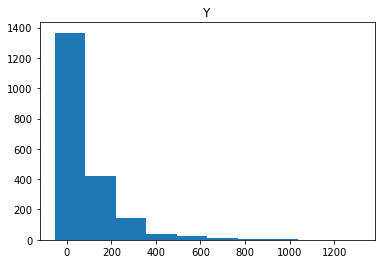

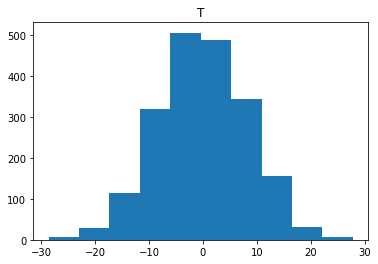

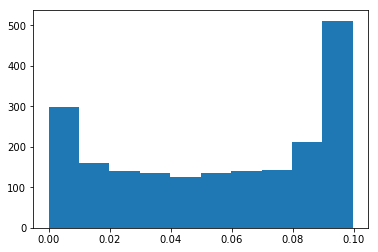

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
import cvxpy as cvx 
# from gurobipy import * 
from off_pol_eval_functions import * 


from scipy.optimize import minimize
import datetime as datetime
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import collections as matcoll
from sklearn import svm
import sys
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

np.random.seed(2)
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

d = 10  # dimension of x 
n = 2000; 
mu_x = np.zeros(d); 
sigma_x = np.random.normal(size = (d,1))
sigma_x += np.abs(np.min(sigma_x))+0.5
sigma_x = np.multiply(sigma_x, np.eye(d))
sigma_x /= 2# normalize covariances a little bit 

W = 1.5 #treatment effect
# interact_x = 2
white_noise_coef = 0.1


# generate propensity model 
def real_prop(x, beta_prop): 
    T_SIG = 5
    if len(x.shape) > 1: 
        n= x.shape[1]
    else:
        n= len(x)
    return np.dot(x, beta_prop) + np.random.normal(size = (n,1))*T_SIG
    # T is normally distributed conditional on covariates 
    
# coefficient of treatment effect
beta_cons = -5
beta_x = np.random.normal(size = (d,1))
# interaction term with treatment 
beta_x_T = np.random.normal(size = (d,1))*1.5

# sparse interaction terms 
sparse_entries = np.random.choice(range(d),size =  int(round(0.7*d)),replace = False)
beta_x_T[sparse_entries] = 0     
sparse_entries = np.random.choice(range(d),size =  int(round(0.35*d)),replace = False)
beta_x[sparse_entries] = 0  

FREQ = 20 
beta_x_quad_T = np.random.normal(size = (d,1))
sparse_entries = np.random.choice(range(d),size =  int(round(0.65*d)),replace = False)
beta_x_quad_T[sparse_entries] = 0

TRUE_PROP_BETA = np.asarray(beta_x_quad_T + np.random.normal( loc= np.ones((d,1))*2, size = (d,1))).flatten()
print TRUE_PROP_BETA
def real_risk(T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x):    
    n = len(T); risk = np.zeros(n)
    if np.isscalar(T):
        risk = T*beta_cons + np.dot(beta_x.T, x) + np.dot(beta_x_T.T, x*T) + (T-np.dot(beta_x_quad_T.T,x))**2
    else: 
        for i in range(len(T)): 
            risk[i] = T[i]*beta_cons + np.dot(beta_x.T, x[i,:]) + np.dot(beta_x_T.T, x[i,:]*T[i]) + (T[i]-np.dot(beta_x_quad_T.T,x[i,:]))**2#+ np.dot(beta_x_quad_T.T, (x[i,:]**2)*T[i]) + np.dot(beta_x_high_freq.T, np.sin(x[i,0:HIGH_FREQ_N]*FREQ)*T[i])
    return risk

T_SIG = 4
def generate_data(mu_x, sigma_x_mat, n, beta_cons, beta_x, beta_x_T): 
#     x = np.random.normal(mu_x, sigma_x, size = n)
    # generate n datapoints from the same multivariate normal distribution
    x = np.random.multivariate_normal(mean = mu_x, cov= sigma_x_mat, size = n ) 
    print x.shape 
    print "xshape"
    T = np.random.normal(0, T_SIG, n) + np.dot(x, TRUE_PROP_BETA) + 2*x[:,1] + 4*x[:,2] - 2*x[:,3]
    true_resid = T - np.dot(x, TRUE_PROP_BETA)
    true_Q = norm.pdf( T - np.dot(x, TRUE_PROP_BETA), loc = 0, scale = T_SIG )
    y_sigma = 0.5
    white_noise_coef = 5
    
    clf = LinearRegression(); clf.fit(x, T)
    y_hat = clf.predict(x)
    Y = np.zeros(n)
    for i in range(n): 
        Y[i] = T[i]*beta_cons + np.dot(beta_x.T, x[i,:]) + T[i]*np.dot(beta_x_T.T, x[i,:]) + (T[i] - np.dot(beta_x_quad_T.T,x[i,:]))**2 #+ np.dot(beta_x_quad_T.T, (x[i,:]**2)*T[i]) + np.dot(beta_x_high_freq.T, np.sin(x[i,0:HIGH_FREQ_N]*FREQ)*T[i])
    Y += np.random.multivariate_normal(mean = np.zeros(n), cov=white_noise_coef * np.eye(n))
    # get pdf from residuals 
    resid = Y - y_hat
    # get norm pdf 
    Q = norm.pdf(resid, loc = np.mean(resid), scale=np.std(resid))
    T = T.flatten()
    return [x, T, Y, true_Q, clf]

[x_full, T_full, Y_full, true_Q_full, clf] = generate_data(mu_x, sigma_x, n, beta_cons, beta_x, beta_x_T)

#compute real risk 
print np.mean( real_risk(T_full, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_full))

plt.hist(Y_full); plt.title('Y')
plt.figure()
plt.title('T')
plt.hist(T_full)
Q = true_Q_full
plt.figure()
plt.hist(true_Q_full)


## In this setting the optimal treatment is similar to the observed treatment policy. 

(array([198., 131., 119., 113., 116., 129., 132., 131., 197., 483.]),
 array([2.65065187e-06, 9.97593288e-03, 1.99492151e-02, 2.99224973e-02,
        3.98957796e-02, 4.98690618e-02, 5.98423440e-02, 6.98156262e-02,
        7.97889085e-02, 8.97621907e-02, 9.97354729e-02]),
 <a list of 10 Patch objects>)

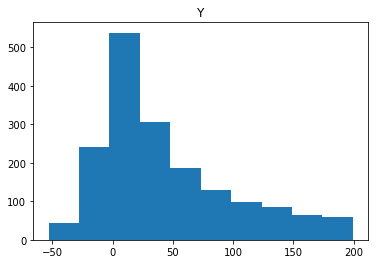

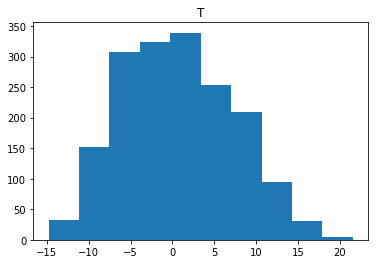

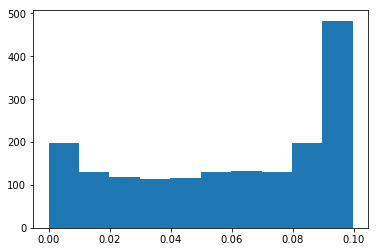

In [2]:
cutoff = 200
x_full=x_full[Y_full < cutoff]
T_full=T_full[Y_full < cutoff]
true_Q_full=true_Q_full[Y_full < cutoff]
Y_full = Y_full[Y_full < cutoff]

plt.hist(Y_full); plt.title('Y')
plt.figure()
plt.title('T')
plt.hist(T_full)
Q = true_Q_full
plt.figure()
plt.hist(true_Q_full)

## Reserve half for out of sample evaluation



In [3]:
n = 1000
x_test = x_full[n:]; Y_test = Y_full[n:]; T_test = T_full[n:]; true_Q = true_Q_full[n:]
x = x_full[0:n]; Y = Y_full[0:n];T = T_full[0:n]; true_Q = true_Q_full[0:n]


## Optimal treatment tends to bounds

In [4]:

# import pickle

# pickle.dump(x_full, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'x.p', 'wb'))
# pickle.dump(T_full, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'T.p', 'wb'))
# pickle.dump(Y_full, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'Y.p', 'wb'))
# pickle.dump(true_Q_full, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'Q.p', 'wb'))


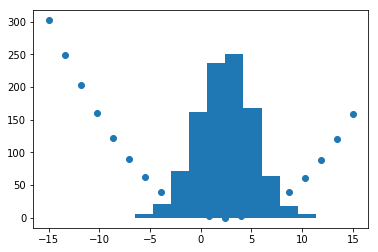

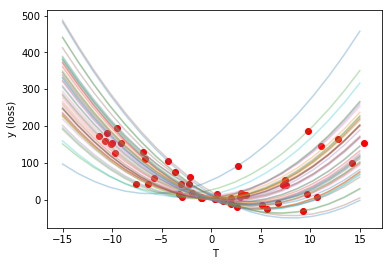

In [5]:
cons_T = np.linspace(-15,15,20)

plt.scatter(cons_T,  [np.mean( real_risk(np.ones(n)*t, beta_cons, beta_x, beta_x_T, beta_x_quad_T,x)) for t in cons_T ] )

def real_risk(T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x):    
    if np.isscalar(T):
        risk = T*beta_cons + np.dot(beta_x.T, x) + np.dot(beta_x_T.T, x*T) + (T-np.dot(beta_x_quad_T.T,x))**2
    else: 
        risk = np.zeros(len(T))
        for i in range(len(T)): 
            risk[i] = T[i]*beta_cons + np.dot(beta_x.T, x[i,:]) + np.dot(beta_x_T.T, x[i,:]*T[i])+ (T[i]-np.dot(beta_x_quad_T.T,x[i,:]))**2 #+ np.dot(beta_x_quad_T.T, (x[i,:]**2)*T[i]) + np.dot(beta_x_high_freq.T, np.sin(x[i,0:HIGH_FREQ_N]*FREQ)*T[i])
    return risk
def real_risk_scalar(T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x):    
    return T*beta_cons + np.dot(beta_x.T, x) + np.dot(beta_x_T.T, x*T) + (T-np.dot(beta_x_quad_T.T,x))**2

bounds = [(min(T)/(0.5*d) , max(T)/np.abs(0.5*d)  ) for i in range(d) ]
bnds = tuple(tuple(x) for x in bounds)

def get_oracle_treatment(beta_cons, beta_x, beta_x_T, beta_x_quad_T, x): 
    res = minimize(real_risk_scalar, np.mean(T), args =(beta_cons, beta_x, beta_x_T, beta_x_quad_T,x))
    return res.x 

oracle_T = [ get_oracle_treatment(beta_cons, beta_x, beta_x_T, beta_x_quad_T, x[i,:]) for i in range(n)]
plt.hist(np.asarray(oracle_T))

fig=plt.figure()
for i in range(50): 
    plt.plot(cons_T, np.asarray([ real_risk(t, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x[i,:]) for t in cons_T ]), alpha = 0.3 )

for i in range(50): 
    plt.scatter(T[i], real_risk(T[i], beta_cons, beta_x, beta_x_T, beta_x_quad_T, x[i,:]),color='r')
plt.xlabel('T')
plt.ylabel('y (loss)')
# plt.axis('off')


fig.savefig('outcome-model.pdf')

# Constant policy 

In [6]:
# real_risk(disc_res,  )
# disc_res

NameError: name 'disc_res' is not defined

In [7]:
LAMBDA = -3

def pol_eval_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    data['tau'] = tau
    return data['sgn']*(off_policy_evaluation(**data))

def pol_eval_l2_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    data['tau'] = tau
    return data['sgn']*(off_policy_evaluation(**data) + LAMBDA * np.linalg.norm(beta,2))


def pol_eval_l1_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    data['tau'] = tau
    return data['sgn']*(off_policy_evaluation(**data) + LAMBDA * sum(abs(beta)))

def off_policy_evaluation(**params):
    """
    Takes in a choice of kernel and dictionary of parameters and data required for evaluation
    tau is a vector of treatment values (assumed given)
    If y_samp, T_samp is present, use that instead. 
    """
    THRESH = params['threshold']
    y_out = params['y']; x = params['x']; h = params['h'];Q = params['Q']; n = params['n']; t_lo = params['t_lo'];  t_hi = params['t_hi']
    kernel = params['kernel_func'];kernel_int =  params['kernel_int_func']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp']
    if ('T_samp' in params.keys()): 
        T = params['T_samp']
    else: 
        T = params['T']
    if ('x_samp' in params.keys()):
        x = params['x_samp']
    loss = 0
    tau = params['tau']
    clip_tau = np.clip(tau, t_lo, t_hi)
    for i in np.arange(n): 
        Q_i = Q(x[i,:], T[i], t_lo, t_hi)
        if (abs(clip_tau[i] - t_lo) <= h):
            alpha = kernel_int((t_lo-clip_tau[i])/h, 1)
            if alpha < 0.5: 
                print alpha
        elif (abs(clip_tau[i] - t_hi) <= h):
            alpha = kernel_int(-1,  (t_hi - clip_tau[i])/h )
            if alpha < 0.5: 
                print alpha
        else:
            alpha = 1
        loss += kernel( (clip_tau[i] - T[i])/h )*1.0 * y_out[i]/max(Q_i,THRESH) * 1.0/alpha
    return loss/(1.0*h*n)


def off_pol_epan_lin_l2_grad(beta, *args):
    """
    Compute a gradient for special case of Epanechnikov kernel and linear policy tau
    """
    # THRESH = 0.001
    d = len(beta) 
    params = dict(args[0])
    #! FIXME x vs xsamp
    tau = np.dot(beta, params['x'].T)
    params['tau'] = tau
    params['beta'] = beta

    THRESH = params['threshold']

    [f, g, nabla_f, nabla_g] = f_g(**params)
    # compute gradient vector via quotient rule
    if g < THRESH: 
        g = THRESH  
    
    return params['sgn']*(np.asarray((g*nabla_f - f*nabla_g) / g**2 ) + LAMBDA * 2*beta)

def off_pol_epan_lin_l1_grad(beta, *args):
    """
    Compute a gradient for special case of Epanechnikov kernel and linear policy tau
    """
    d = len(beta) 
    params = dict(args[0])
    #! FIXME x vs xsamp
    tau = np.dot(beta, params['x'].T)
    params['tau'] = tau; params['beta'] = beta
    THRESH = params['threshold']
    [f, g, nabla_f, nabla_g] = f_g(**params)
    # compute gradient vector via quotient rule
    if g < THRESH: 
        g = THRESH  
    l1_sub = np.zeros(d)
    for i in range(d): 
        if beta[i] < 0: 
            l1_sub[i] = -1 
        elif beta[i] > 0: 
            l1_sub[i] = 1
        else: 
            l1_sub[i] = 0 
    return params['sgn']*(np.asarray((g*nabla_f - f*nabla_g) / g**2 ) + LAMBDA * l1_sub)

def f_g(**params): 
    THRESH = params['threshold']
    y_out = params['y']; x = params['x']; h = params['h'];Q = params['Q']; n = params['n']; t_lo = params['t_lo'];  t_hi = params['t_hi']
    kernel = params['kernel_func'];kernel_int =  params['kernel_int_func']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp']
    if ('T_samp' in params.keys()): 
        T = params['T_samp']
    else: 
        T = params['T']
    if ('x_samp' in params.keys()):
        x = params['x_samp']
    BMI_IND = params.get('BMI_IND') # propensity score for warfarin data evaluations 
        
    loss = 0
    g = 0 # also keep track of normalized probability ratio quantity 
    partial_f = 0 
    partial_g = 0 
    tau = params['tau']
    clip_tau = np.clip(tau, t_lo, t_hi)
    Qs = np.zeros(n)
    for i in np.arange(n): 
        if (params.get('DATA_TYPE') == 'warfarin'): 
            Q_i = Q(x[i,BMI_IND], T[i], t_lo, t_hi)
        else: 
            Q_i = Q(x[i], T[i], t_lo, t_hi)
        if (abs(clip_tau[i] - t_lo) <= h):
            alpha = kernel_int((t_lo-clip_tau[i])/h, 1)
        elif (abs(clip_tau[i] - t_hi) <= h):
            alpha = kernel_int(-1,  (t_hi - clip_tau[i])/h )
        else:
            alpha = 1
        Qs[i] = kernel( (clip_tau[i] - T[i])/h )/max(Q_i,THRESH)
        loss += kernel( (clip_tau[i] - T[i])/h )*1.0 * y_out[i]/max(Q_i,THRESH) * 1.0/alpha
        if abs((clip_tau[i] - T[i])/h) >= 1:
            partial_f += 0 # don't add anything to partial derivatives 
        else:
            partial_g += -1.5 * ((clip_tau[i] - T[i])/h ) * 1.0/max(Q_i,THRESH) * x[i,:]
            partial_f += -1.5 * ((clip_tau[i] - T[i])/h ) * y_out[i]/max(Q_i,THRESH) * x[i,:]
    norm_sum = np.mean(Qs)
    return [loss/(1.0*h*n), 1.0*norm_sum/h, partial_f/(1.0*n*h**2) , partial_g/(1.0*n*h**2) ]




In [8]:
def oracle_eval_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    x = data['x']
    return np.mean(real_risk(tau, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x))



In [9]:
## Train GPS on your simulated data
def norm_T_Q(x,t,t_lo,t_hi): 
    return norm.pdf( t - np.dot(x, TRUE_PROP_BETA), loc = 0, scale = T_SIG )

trainind = np.random.choice(range(n),size = int(round(0.4*n)),replace = False)
train = x[trainind]
test_mask = np.ones(n, dtype=bool)
test_mask[trainind] = False
test = x[test_mask,:]
t_lo = min(T)
t_hi = max(T) 
d = x.shape[1]
train_data = { 'n': train.shape[0],'h': 4, 'y': Y[trainind],'Q': norm_T_Q,'x_full': x[trainind], 'x': x[trainind],'x_samp': x[trainind], 'T_samp': T[trainind], 'd': d, 'T': T[trainind],'t_lo': t_lo ,'t_hi': t_hi  }
train_data['kernel_int_func'] = epanechnikov_int
train_data['T_samp'] = np.array(T[trainind],order='F'); train_data['y_samp'] = Y[trainind]
train_data['kernel_func'] = epanechnikov_kernel
train_data['inds'] = trainind
train_data['threshold'] = 0.01


In [10]:

def discretize_tau_policy(**params):
    '''
    Discretize the treatment vector 'tau' according to uniform binning.
    '''
    x = params['x_samp']
    T = params['T_samp']
    n_bins = params['n_bins']
    t_lo = min(T)
    t_hi = max(T)
    bins = np.linspace(t_lo, t_hi, n_bins)
    T_binned = np.digitize(T, bins).flatten()
    bin_means = [T[T_binned == i].mean() for i in range(1, n_bins)]
    tau_binned = np.digitize(params['tau'], bins).flatten()
    return tau_binned

def off_pol_disc_evaluation(policy, **params):
    THRESH = params['threshold']
    y_out = params['y']; x = params['x_samp']; h = params['h']; Q = params['Q']; n = params['n']; t_lo = params['t_lo']; t_hi = params['t_hi']
    n_bins = params['n_bins']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp'].flatten()
    if ('T_samp' in params.keys()):
        T = params['T_samp'].flatten()
    else:
        T = params['T'].flatten()

    t_lo = min(T)
    t_hi = max(T)
    bin_width = t_hi-t_lo
    bins = np.linspace(t_lo, t_hi, n_bins)
    T_binned = np.digitize(T, bins, right = True).flatten()
    bin_means = [T[T_binned == i].mean() for i in range(1, len(bins))]

    loss = 0
    tau_vec = policy(**params).flatten()

    i=0
    #! FIXME need to establish whether policy returns discrete bins or means
    treatment_overlap = np.where(np.equal(tau_vec.flatten(), T_binned))[0]
    n_overlap = len(treatment_overlap)
    Qs = np.zeros(n_overlap)
    for ind in treatment_overlap:
        Q_i = Q(x[ind], bin_means[T_binned[ind]-1], t_lo, t_hi) * bin_width*1.0/n_bins # BUG FIX: this is going to have to be integrated against 
        Qs[i] = 1.0/max(Q_i,THRESH)
        loss += y_out[ind]/max(Q_i,THRESH)
        i+=1 
    
    norm_sum = np.mean(Qs)
    if n_overlap == 0:
        print "no overlap"
        return 0
    return loss/(1.0*n*norm_sum)

def pol_disc_l2_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']; pol = data['pol']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    data['tau'] = tau
    return data['sgn']*(off_pol_disc_evaluation(pol,**data) + LAMBDA * np.linalg.norm(beta,2))



In [11]:
t_lo = min(T)
t_hi = max(T)
bins = np.linspace(t_lo, t_hi, n_bins)
T_binned = np.digitize(T, bins).flatten()
bin_means = [T[T_binned == i].mean() for i in range(1, n_bins)]

NameError: name 'n_bins' is not defined

In [432]:
data = { 'n': nn,'h': 5*pow((n_0*1.0/nn),.2), 'y': Y[trainind],'Q': norm_T_Q,'x_full': x[trainind,:], 'x': x[trainind,:],'x_samp': x[trainind,:], 'T_samp': T[trainind].flatten(), 'd': d, 'T': T[trainind],'t_lo': t_lo ,'t_hi': t_hi  }
data['kernel_int_func'] = epanechnikov_int
data['T_samp'] = np.array(T[trainind],order='F'); train_data['y_samp'] = Y[trainind]
data['kernel_func'] = epanechnikov_kernel
data['inds'] = trainind; data['sgn'] = 1
data['threshold'] = 0.02

data['n_bins'] = 10 
data['pol'] = discretize_tau_policy
data['tau'] = T[trainind]
off_pol_disc_evaluation(discretize_tau_policy, **data)
beta_d = np.random.uniform(size=(d,1))*4
disc_res = minimize(pol_disc_l2_wrapper, x0 = beta_d, bounds = bnds, options={'disp':True,'gtol':1e-1,'maxfun': 1000}, args=data.items())
data['tau'] = np.dot(disc_res.x, x.T)
disc_pol = discretize_tau_policy(**data)
disc_T= np.dot(disc_res.x, x.T)
np.mean( real_risk(np.dot(disc_res.x, x.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x) )

5.3017425743851954

(array([    0.,     0.,     0.,     0.,     0.,  1000.,     0.,     0.,
            0.,     0.]),
 array([ 1.12933997,  1.22933997,  1.32933997,  1.42933997,  1.52933997,
         1.62933997,  1.72933997,  1.82933997,  1.92933997,  2.02933997,
         2.12933997]),
 <a list of 10 Patch objects>)

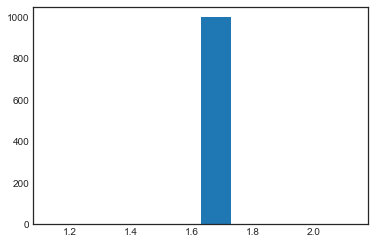

In [362]:
import cvxpy as cvx
np.random.seed(2)

n = len(Y)
SAMP_N = 5; 
ns = [200, 400]#, 800, 1600 ]
n_0 = ns[0]
cons_evals = np.zeros([len(ns), SAMP_N]); mean_evals = np.zeros([len(ns), SAMP_N])
zero_evals = np.zeros([len(ns), SAMP_N]); oracle_evals = np.zeros([len(ns), SAMP_N]);DR_oracle_evals = np.zeros([len(ns), SAMP_N])
oracle_coefs = [ [None]*SAMP_N ] * len(ns)
DR_oracle_coefs = [ [None]*SAMP_N ] * len(ns)
bounds = [(min(T)/(0.5*d) , max(T)/np.abs(0.5*d)  ) for i in range(d) ]
bnds = tuple(tuple(x) for x in bounds)
# bounds = [(-np.mean(sampled_T)/max(np.mean(X_sim_std[:,i]), 0.25*d) , np.mean(sampled_T)/max(np.mean(X_sim_std[:,i]),d*.25) ) for i in range(d) ]
# bounds = [(-max(sim_dose)/(.25*d*np.mean(subframe[:,i])) , max(sim_dose)/(.25*d*np.mean(subframe[:,i])) ) for i in range(d) ]
print "opt coef bounds for beta: "
print bounds

n_restarts = 1
for ind, nn in enumerate(ns): 
    print nn 
    for k in range(SAMP_N): 
        trainind = np.random.choice(range(n),size = nn, replace = False)
        sub_T = np.zeros(nn)
        
        # Learn GPS from data
        lr = LinearRegression(); lr.fit(x[trainind,:], T[trainind])
        T_hat = lr.predict(x[trainind,:])
        beta_T_gps = np.dot(x[trainind,:],lr.coef_)
        resid = T[trainind] - T_hat
        # Assume normal noise
        mu_resid = np.mean(resid); sigma_resid = np.std(resid)
        def norm_T_Q_est(x,t,t_lo,t_hi): 
            return norm.pdf( t - np.dot(x, lr.coef_), loc =  mu_resid, scale = sigma_resid )
        
        data = { 'n': nn,'h': 3*pow((n_0*1.0/nn),.2), 'y': Y[trainind],'Q': norm_T_Q_est,'x_full': x[trainind,:], 'x': x[trainind,:],'x_samp': x[trainind,:], 'T_samp': T[trainind].flatten(), 'd': d, 'T': T[trainind],'t_lo': t_lo ,'t_hi': t_hi  }
        data['kernel_int_func'] = epanechnikov_int
        data['T_samp'] = np.array(T[trainind],order='F'); train_data['y_samp'] = Y[trainind]
        data['kernel_func'] = epanechnikov_kernel
        data['inds'] = trainind; data['sgn'] = 1
        data['threshold'] = 0.02
        betas = []; vals = []
        
        k_ind = 0
        while k_ind <= n_restarts: 
            k_ind += 1
            beta_d = np.random.uniform(size=d)
            LAMBDA = 0.5
            oracle_res = minimize(pol_eval_l2_wrapper, x0 = beta_d, jac = off_pol_epan_lin_l2_grad, bounds = bnds, options={'disp':True,'gtol':1e-1,'maxfun': 1000}, args=data.items())  
            betas += [oracle_res.x]
            print oracle_res.x
            vals += [oracle_res.fun]
            print oracle_res.fun
        oracle_coefs[ind][k] = betas[np.argmin(vals)] 
        oracle_evals[ind, k] = vals[np.argmin(vals)] 
        zero_T = np.zeros(nn); data['tau'] = zero_T; zero_evals[ind,k] = off_policy_evaluation(**data)
#         oracle_coefs[ind] += [ betas[np.argmin(vals)] ]
#         oracle_evals[ind, k] = vals[np.argmin(vals)]
        mu_T = np.mean(T)*np.ones(nn); data['tau'] = mu_T; mean_evals[ind,k] = off_policy_evaluation(**data)
        
        clf = RandomForestRegressor(n_estimators=5)
        clf = clf.fit(x[trainind,:],y=Y[trainind])
#         data['rf'] = clf
        y_hat = clf.predict(x[trainind,:])
        data['y'] = Y[trainind] - y_hat
        betas = []; vals = []
        k_ind = 0
        while k_ind <= n_restarts: 
            k_ind += 1
            beta_d = np.random.uniform(size=d)
            LAMBDA = 0.5
            oracle_res = minimize(pol_eval_l2_wrapper, x0 = beta_d, jac = off_pol_epan_lin_l2_grad, bounds = bnds, options={'disp':True,'gtol':1e-1,'maxfun': 1000}, args=data.items())  
            print oracle_res.x
            betas += [oracle_res.x]
            vals += [oracle_res.fun]
            print oracle_res.fun
        DR_oracle_coefs[ind][k] = betas[np.argmin(vals)] 
        DR_oracle_evals[ind, k] = vals[np.argmin(vals)] 
        
        data['n_bins'] = 10 
        off_pol_disc_evaluation(discretize_tau_policy, **data)
        
        ## Best-in-class policy via regression
        # find best in class policy 
#         d = x.shape[1]; beta = cvx.Variable(d)
#         # Implement a thresholded loss
#         cost = cvx.sum_entries(cvx.square(x[trainind,:]*beta)) # minimize y^2 
#         constraints = [beta >=min(T)/(0.5*d) ]
#         for i in range(d): 
#             constraints += [beta[i] <= max(T)/(0.5*d) ]
#         prob = cvx.Problem(cvx.Minimize(cost), constraints)
#         prob.solve('SCS')
#         print beta.value
#         prescient_beta = beta.value.flatten().T
#         prescient_beta = np.ravel(prescient_beta).T
        


opt coef bounds for beta: 
[(-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438), (-2.9558302454279373, 3.6139946196115438)]
200
[-0.11307281 -0.87557897 -0.2221516  -0.01761266 -0.2977354   0.24907352
  0.11314573  0.0313166   0.0857681   0.45362848]
2.53700237051
[ 0.15080832 -0.80299567 -0.03155778  0.02964014 -0.1331966   0.20039607
  0.03042686  0.11666065  0.03919754  0.81400155]
2.60750146004
[ 1.30859075 -1.65956808  0.79758927 -1.08244053  0.58893735 -0.40808881
  2.22151267  0.62148064  1.46108363  0.38589725]
-16.2167815295
[ 0.32919023 -0.6009378  -0.01417606  0.63285094  0.61394999  0.39117909
  1.17146372 -0.01390529  0.24757144  0.99251226]
-10

$$ \beta^T X + \beta_{x,T}*X\circ T + (\beta_{x,T^2}^T x - T)^2$$

Suppose we replace T with the linear policy $\beta_{\tau}x$: 

$$ \beta^T X + \beta_{x,T}*X\circ \beta_{\tau}X + ((\beta_{x,T^2} - \beta_{\tau})^T X)^2 $$ 

If we derive wrt $\beta_{\tau x}$: 

$$ \beta_{x,T}X +2(\beta_{x,T^2}^T X - \beta_{\tau}X)X = 0 $$

$$\beta_{\tau}^T X)X =  \beta_{x,T}X +2\beta_{x,T^2}^T X $$

$$\beta_{\tau}^T  =  (\beta_{x,T}X +2\beta_{x,T^2}^T X)(X^TX)^{-1} $$

In [336]:
def oracle_eval_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    x = data['x']
    return np.mean(real_risk(np.dot(tau, x), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x))
beta_d = np.random.uniform(size=(d,1))*5
best_in_class = minimize(oracle_eval_wrapper, x0 = beta_d, bounds = bnds, options={'disp':True,'gtol':1e-1,'maxfun': 1000}, args=data.items())  
print best_in_class.x
print best_in_class.fun


[-0.00435006  0.01131169  0.02045897  0.00788028 -0.00518324 -0.01321837
 -0.00207648  0.00110226  0.00821719  0.00261471]
-5.13967400903


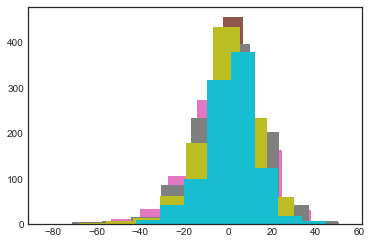

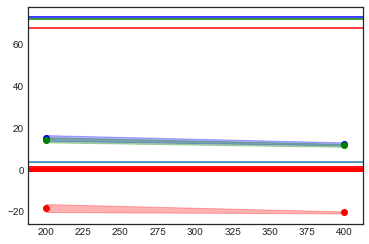

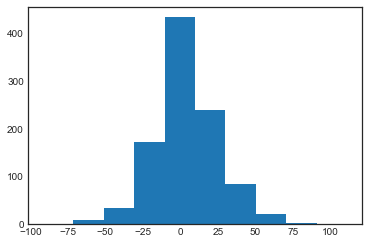

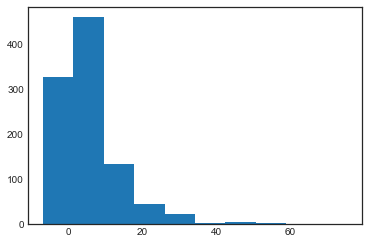

In [281]:

def real_risk(T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x):    
    n = len(T); risk = np.zeros(n)
    if np.isscalar(T):
        risk = T*beta_cons + np.dot(beta_x.T, x) + np.dot(beta_x_T.T, x*T) + (T-np.dot(beta_x_quad_T.T,x))**2
    else: 
        for i in range(len(T)): 
            risk[i] = T[i]*beta_cons + np.dot(beta_x.T, x[i,:]) + np.dot(beta_x_T.T, x[i,:]*T[i]) + (T[i]-np.dot(beta_x_quad_T.T,x[i,:]))**2#+ np.dot(beta_x_quad_T.T, (x[i,:]**2)*T[i]) + np.dot(beta_x_high_freq.T, np.sin(x[i,0:HIGH_FREQ_N]*FREQ)*T[i])
    return risk

zero_T = np.zeros(n); 
# pred_T = np.dot(oracle_coefs[1][0], x.T)
dr_T = np.dot(DR_oracle_coefs[1][0], x.T)
colors = ['b', 'g', 'r', 'y','orange']
EVALS = [zero_evals, mean_evals, DR_oracle_evals]

# use scipy minimize (1D optimize outcome wrt T )
def get_oracle_treatment(beta_cons, beta_x, beta_x_T, x): 
    res = minimize(real_risk, np.mean(T), args =(beta_cons, beta_x, beta_x_T, beta_x_quad_T, x))
    return res.x 

POLICIES = [ zero_T, mu_T, dr_T ]
lbls = ['zero treatment policy', 'mean treatment policy', 'DR treatment policy'   ]

def plot_evals(evals, POLICY, X, c, lbl, ns, SAMP_N): 
    plt.axhline(y = Y_OFFSET + np.mean(real_risk(POLICY, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)),color=c)
    plt.scatter(ns, np.mean(evals,axis=1),label=lbl,color=c)
    error = 1.96*np.std(evals,axis=1)/np.sqrt(SAMP_N)
    plt.fill_between(ns, np.mean(evals,axis=1)-error,np.mean(evals,axis=1)+error, alpha=0.3, edgecolor=c, facecolor=c)
# plt.axhline(y = np.mean(real_risk(oracle_T beta_cons, beta_x, beta_x_T, x)))


plt.figure()
for j in range(len(ns)):
    for i in range(SAMP_N): 
        plt.hist( np.asarray(real_risk(np.dot(DR_oracle_coefs[j][i], x.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)).flatten())

plt.figure()
[ plot_evals(EVALS[i], POLICIES[i], x, colors[i], lbls[i], ns, SAMP_N) for i in range(len(EVALS))]
for j in range(len(ns)):
    for i in range(SAMP_N): 
        plt.axhline(y = np.mean(real_risk(np.dot(oracle_coefs[j][i], x.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)),color='r')
    for i in range(SAMP_N): 
        plt.axhline(y = np.mean(real_risk(np.dot(DR_oracle_coefs[j][i], x.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)),color='r')
plt.axhline(y = np.mean(real_risk(np.dot(oracle_res.x, x.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)))

plt.figure()
plt.hist(real_risk(np.dot(oracle_res.x, x.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x))
# plt.axhline(y = np.mean(real_risk(pred_T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)),color=c)
plt.figure()
plt.hist(real_risk(zero_T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x))


# def plot_evals(evals, POLICY, X, c, lbl, ns, SAMP_N): 
#     plt.axhline(y = np.mean(real_risk(POLICY, beta_cons, beta_x, beta_x_T, x)),color=c)
#     plt.scatter(ns, np.mean(evals,axis=1),label=lbl,color=c)
#     error = 1.96*np.std(evals,axis=1)/np.sqrt(SAMP_N)
#     plt.fill_between(ns, np.mean(evals,axis=1)-error,np.mean(evals,axis=1)+error, alpha=0.5, edgecolor=c, facecolor=c)
# plt.axhline(y = np.mean(real_risk(oracle_T, beta_cons, beta_x, beta_x_T, x)))
# [ plot_evals(EVALS[i], POLICIES[i], x, colors[i], lbls[i], ns, SAMP_N) for i in range(len(EVALS))]

import pickle
plt.figure()
for i in range(len(EVALS)):  
    pickle.dump(EVALS[i], open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) +lbls[i]+ 'EVALS.p', 'wb'))
    pickle.dump(POLICIES[i], open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) +lbls[i]+ 'policy.p', 'wb'))
    pickle.dump(oracle_coefs, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) +lbls[i]+ 'oracle_coefs.p', 'wb'))
    pickle.dump(DR_oracle_coefs, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) +lbls[i]+ 'DR_oracle_coefs.p', 'wb'))



(array([  10.,   45.,  124.,  184.,  204.,  200.,  135.,   66.,   27.,    5.]),
 array([-13.49061212, -10.5721903 ,  -7.65376848,  -4.73534666,
         -1.81692484,   1.10149698,   4.0199188 ,   6.93834062,
          9.85676244,  12.77518426,  15.69360608]),
 <a list of 10 Patch objects>)

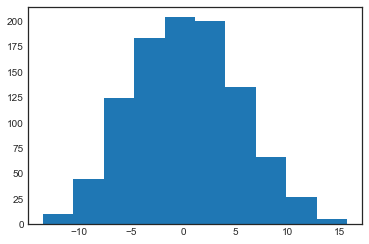

In [328]:
plt.hist(T)

In [452]:
# Impute POEM 
import sys
sys.path.append('./POEM-norm/')
import DatasetReader, Skylines

def norm_T_Q(x,t,t_lo,t_hi): 
    return norm.pdf( t - np.dot(x, TRUE_PROP_BETA), loc = 0, scale = T_SIG )

t_lo = min(T)
t_hi = max(T)
bins = np.linspace(t_lo, t_hi, n_bins)
bin_width = (t_hi-t_lo)*1.0/n_bins
T_binned = np.digitize(T, bins,right=True).flatten()
bin_means = [T[T_binned == i].mean() for i in range(1, n_bins)]
Xtrain = x[trainind,:]
ttrain = T_binned[trainind]

gps = np.asarray([bin_width*norm_T_Q(x[i,:], bin_means[ttrain[i]-1], 0.5, 0.5 ) for i in range(len(trainind))])
# all 0-1
# gps = integrated_propensity_scores
ytrain = Y[trainind]
Xtest = x

mydata = DatasetReader.BanditDataset(None,False)
mydata.trainFeatures        = np.hstack((Xtrain.copy(),np.ones((len(Xtrain),1))))
mydata.sampledLabels        = np.zeros((len(ttrain),max(ttrain)+1))
mydata.sampledLabels[range(len(ttrain)),ttrain] = 1.
mydata.trainLabels          = np.empty(mydata.sampledLabels.shape)
mydata.sampledLoss          = ytrain.copy()
mydata.sampledLoss         -= mydata.sampledLoss.min()
mydata.sampledLoss         /= mydata.sampledLoss.max()
# computed on training set 
mydata.sampledLogPropensity = np.log(gps)
#ones_like vs ones_line? 
mydata.testFeatures              = np.hstack((np.ones_like(Xtest),np.ones((len(Xtest),1))))
mydata.testLabels                = np.array([])
mydata.createTrainValidateSplit()
pool = None 
coef = None

maj = Skylines.PRMWrapper(mydata, n_iter = 1000, tol = 1e-6, minC = 0, maxC = -1, minV = 0, maxV = -1,
                            minClip = 0, maxClip = 0, estimator_type = 'Self-Normalized', verbose = True,
                            parallel = pool, smartStart = coef)
maj.calibrateHyperParams()
maj.validate()
Xtest1 = np.hstack((Xtest,np.ones((len(Xtest),1))))
rec = Xtest1.dot(maj.labeler.coef_).argmax(1)



Calibrating clip to  6.93507159806
Calibrating variance regularizer to  774.172130334
PRM(Self-Normalized-ERM)  Best. Parameter =  {'varpenalty': 0.0, 'l2reg': 0, 'clip': 6.9350715980596425} Time:  0.0185790061951  ClippedDiagnostic:  2.81444380731e-06 UnclippedDiagnostic:  2.81444380731e-06  Performance:  None


[-11.981815426936143,
 -9.0064932552158528,
 -5.5881381267090555,
 -1.8942891665267862,
 1.6293399730948344,
 5.3301456637254274,
 8.7249863215911514,
 12.268056421501164,
 15.814595553523269]

100.353197267
79.9704574287


(array([  11.,  312.,  201.,  171.,  152.,   88.,   33.,   24.,    6.,    2.]),
 array([ -86.73588356,  -28.25840323,   30.21907711,   88.69655744,
         147.17403778,  205.65151811,  264.12899844,  322.60647878,
         381.08395911,  439.56143945,  498.03891978]),
 <a list of 10 Patch objects>)

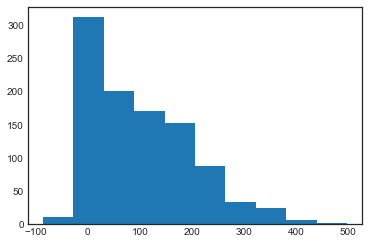

In [453]:
POEM_pol =  [bin_means[rec[i]-1] for i in range(n)]  
# print POEM_pol
POEM_risk = real_risk(POEM_pol, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)
print np.mean(POEM_risk)
print np.median(POEM_risk)
plt.hist(POEM_risk)


In [295]:
X_w_dose

array([[ -1.51635123,  -0.76968095,   0.0332445 , ...,  -0.58029878,
          0.68329363,   3.17487636],
       [ -0.09633913,  -3.02051254,   0.62410646, ...,  -0.16831035,
         -1.88969581,  -0.93700002],
       [  1.28295978,   1.55285965,   0.70334812, ...,   0.33922146,
          0.32607988,  11.66598013],
       ..., 
       [ -0.84835847,  -1.78056669,   0.28752181, ...,   0.45480389,
          0.97962469,   0.69258063],
       [ -0.41519852,  -0.65276462,  -0.31912961, ...,  -0.38795049,
          1.01675513,   3.16505215],
       [  0.32207699,  -2.34564014,   0.25879004, ...,  -0.92527222,
         -0.46216755,   5.78096866]])

DM with random forest regressor

In [377]:
from sklearn.ensemble import RandomForestRegressor

X_w_dose = np.column_stack((x, T))
X_w_dose.shape

clf = RandomForestRegressor(n_estimators=10)

clf = clf.fit(X_w_dose[trainind,:],y=Y[trainind])
data['x_full'] = X_w_dose[trainind,:]
data['rf'] = clf
print clf.score(X_w_dose,Y)

def dm_wrapper(beta, args): 
    reg_lambda = 0.5
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    x = data['x_full']
    clf = data['rf']
    tau = np.clip(np.dot( beta, x[:,:-1].T ), t_lo, t_hi).flatten()
    counterfactual_X = np.column_stack((x[:,:-1], tau))
    return (np.mean( clf.predict( counterfactual_X )) + reg_lambda * np.linalg.norm( beta, 2 )) 

dm_res = minimize(dm_wrapper, x0 = beta_d, bounds = bnds, options={'disp':True,'gtol':1e-1,'maxfun': 1000,'eps':np.ones(d)*1e-1}, args=data.items()) 
print dm_res.x



0.876501283585
[-0.14869785 -1.94284229  0.29220843  0.07710959  0.6036456  -0.02156021
  0.00812235  0.23521679  0.38506636  0.28939633]


In [378]:
np.mean(T)

0.56422025353847105

0.19847593763428459

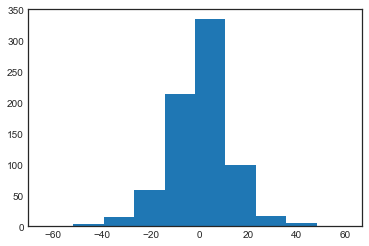

In [379]:

dm_T = np.dot(dm_res.x, x_test.T)

plt.hist(real_risk(dm_T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test))
np.mean(real_risk(dm_T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test))

In [380]:
def get_oracle_treatment(beta_cons, beta_x, beta_x_T, beta_x_quad_T, x): 
    res = minimize(real_risk_scalar, np.mean(T), args =(beta_cons, beta_x, beta_x_T, beta_x_quad_T,x))
    return res.x 
n_test = x_test.shape[0]
oracle_T = [ get_oracle_treatment(beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test[i,:]) for i in range(n_test)]



(array([   1.,    6.,   15.,   68.,  142.,  178.,  194.,  107.,   31.,    7.]),
 array([ -5.83865989e-08,  -4.84677142e-08,  -3.85488295e-08,
         -2.86299449e-08,  -1.87110602e-08,  -8.79217548e-09,
          1.12670921e-09,   1.10455939e-08,   2.09644786e-08,
          3.08833633e-08,   4.08022480e-08]),
 <a list of 10 Patch objects>)

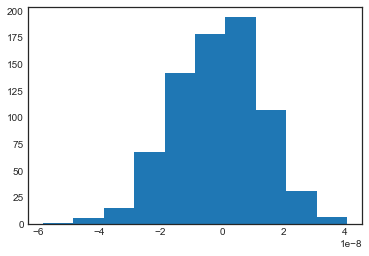

In [402]:
plt.hist(np.dot(disc_res.x, x_test.T))

In [429]:
x_test.shape

(749, 10)

(array([   0.,    0.,    0.,    0.,    0.,  749.,    0.,    0.,    0.,    0.]),
 array([ 1.12933997,  1.22933997,  1.32933997,  1.42933997,  1.52933997,
         1.62933997,  1.72933997,  1.82933997,  1.92933997,  2.02933997,
         2.12933997]),
 <a list of 10 Patch objects>)

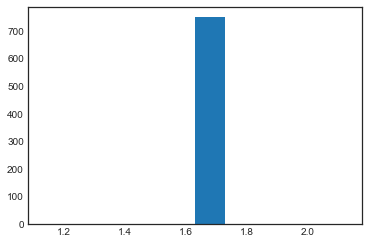

In [433]:
data['x']
data['tau'] = np.dot(disc_res.x, x_test.T)
disc_pol_binned = np.digitize(np.dot(disc_res.x, x_test.T), bins).flatten()
disc_pol = np.asarray( [bin_means[disc_pol_binned[i] - 1] for i in range(x_test.shape[0])] )
plt.hist(disc_pol)

In [437]:

def cons_pol_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = beta*np.ones(data['n'])
    data['tau'] = tau
    return data['sgn']*(off_policy_evaluation(**data))
beta_t = np.random.uniform()*4
bnds_t = tuple([(-15,15)])
cons_res = minimize(cons_pol_wrapper, x0 = beta_t, bounds = bnds_t, options={'disp':True,'gtol':1e-1,'maxfun': 1000}, args=data.items())




In [ ]:
5

In [ ]:
%matplotlib inline
plt.style.use('seaborn-white')
plt.figure()

# Use the same simulated loss function to estimate differences
TRUE_ORACLE = real_risk(oracle_T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
oracle_loss = real_risk(np.dot(best_in_class.x, x_test.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
zero_pol = real_risk(np.zeros(n_test), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
mu_pol = real_risk(np.ones(n_test)*np.mean(T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
DM = real_risk(np.dot(dm_res.x, x_test.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
DR_oracle = real_risk(np.dot(DR_oracle_coefs[1][3],x_test.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
off_pol = real_risk(np.dot(oracle_coefs[1][1],x_test.T), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
disc_pol_norms = real_risk(disc_pol, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)
best_constant = real_risk(cons_res.x*np.ones(n_test), beta_cons, beta_x, beta_x_T, beta_x_quad_T, x_test)


original = real_risk(T, beta_cons, beta_x, beta_x_T, beta_x_quad_T, x)

norms = [TRUE_ORACLE, off_pol,DR_oracle,DM, disc_pol_norms,best_constant, mu_pol, original ]

plt.figure(figsize=(4.5,3))
plt.ylabel('Thresholded absolute policy loss')
flierprops = dict(linestyle='-',color='black')

# prefer to turn off mean line
medianprops = dict(linestyle='', linewidth=0, color='firebrick')
f=plt.figure(figsize=(4.5,2.5))
bp_dict = plt.boxplot(norms,sym='', showmeans = True, meanline=True,medianprops=medianprops)
plt.ylabel('Outcome (loss)')
for whisker in bp_dict['whiskers']:
    whisker.set(color='#000000',linestyle='solid')
for box in bp_dict['boxes']:
    # change outline color
    box.set( color='#000000')
for ind,line in enumerate(bp_dict['means']):
    # get position data for means line
    xx, y = line.get_xydata()[1] # top of means line
    if ind == 7: 
        plt.text(xx-1, 30, '%.1f' % y, horizontalalignment='center',size=13) # draw above, centered
    # overlay median value
    else:
        plt.text(xx+0.2, -35, '%.1f' % y, horizontalalignment='center',size=13) # draw above, centered
# top = 60
# bottom = 0
# plt.ylim(bottom, top)
# plt.title('Boxplot of distances between policy-recommended doses and therapeutic doses',y = 1.2)
# plt.axhline(y=np.mean(mean_dose_pol_norm), xmin=0,xmax=1,color='g', ls='dashdot',linewidth=0.7)
# plt.axhline(y=0, xmin=0,xmax=1,color='g',alpha=0.3, ls='dashed',linewidth=0.7)
plt.xticks([1, 2, 3,4,5,6,7,8], ['best o.o.c.', 'CPO', 'DR CPO', 'DM','Disc. CPO','CPE, cons.', 'Mean','Original'])
plt.xticks(rotation=25)
plt.ylim((-40,40))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
f.savefig("boxplot_risks.pdf", bbox_inches='tight')




plt.show()

f= plt.figure()
plt.violinplot(norms)
plt.xticks([1, 2, 3,4,5,6,7,8], ['Best o.o.c.','OPE', 'DR OPE','DM','Disc. OPE','OPE, cons.','Mean','Original'],size = 13)
plt.xticks(rotation=25)
plt.ylim((-90,70))
for ind,line in enumerate(bp_dict['means']):
    # get position data for means line
    xx, y = line.get_xydata()[1] # top of means line
    if ind == 6: 
        plt.text(xx+0.05, y+3.5, '%.1f' % y, horizontalalignment='center',size=13) # draw above, centered
    # overlay median value
    else:
        plt.text(xx+0.24, y+3.5, '%.1f' % y, horizontalalignment='center',size=13) # draw above, centered

        
f.savefig("violin_plot_risks.pdf", bbox_inches='tight')


In [ ]:
5

In [390]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from statsmodels.nonparametric.kernel_density import EstimatorSettings


settings = EstimatorSettings(efficient = True, randomize=True)
list_data = [ x[trainind,i] for i in range(d) ] + [T[trainind]]
kernel_regr = KernelReg(endog = [Y[trainind].reshape([len(trainind),1])], exog=list_data, var_type=['c']*len(list_data),bw='aic',defaults = settings )

/Users/az/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kernel_regression.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  (1 - (np.trace(H) + 2) / float(self.nobs))


KeyboardInterrupt: 

In [383]:
kernel_regr

NameError: name 'kernel_regr' is not defined